Amazon product rating prediction model

1. Import the library and initialize Settings

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
import os
from datetime import datetime
import joblib
warnings.filterwarnings('ignore')

output_dir = 'model_results'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


2. Problem Definition and Business Understanding



Business Problem:

E-commerce platforms need to predict potential ratings for new products to anticipate market feedback before product launch, helping merchants formulate pricing and marketing strategies. Accurate rating predictions can help merchants identify potential bestsellers and adjust inventory and promotional resource allocation in advance.
Help merchants understand the key factors affecting product ratings, such as pricing strategies (discount intensity, price range), product category characteristics, and level of detail in product descriptions, to optimize product information and improve user satisfaction.
Provide rating prediction support for recommendation systems, optimizing recommendation algorithms by predicting ratings users might give, enhancing shopping experience, increasing user stickiness and platform activity.

Technical Problem:

This is a regression problem, aiming to predict product ratings (1-5 points). Features need to be extracted from structured and unstructured data to build regression models.
Features include:
Price information: Discounted price, original price, discount percentage and other numerical features.
Product categories: Multi-level category structure requiring encoding.
Product description text: Text features extracted through natural language processing (such as TF-IDF features).
Other metadata: Derived features like rating count, product name length, etc.
The challenge lies in handling mixed data types (numerical, textual, categorical) and balancing model complexity with generalization ability to avoid overfitting.
"""

3. Data Loading and Preliminary Exploration

In [7]:

try:
    # Load data
    df = pd.read_csv('amazon.csv')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: amazon.csv file not found, please ensure the file is in the current directory")
    exit()

print("Dataset basic information:")
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

print("\nData types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

print("\nTarget variable initial state:")
print(f"Sample unique values in rating column: {df['rating'].head(10).tolist()}")
print(f"Rating column data type: {df['rating'].dtype}")

Dataset loaded successfully!
Dataset basic information:
Data shape: (1465, 16)
Columns: ['product_id', 'product_name', 'category', 'discounted_price', 'actual_price', 'discount_percentage', 'rating', 'rating_count', 'about_product', 'user_id', 'user_name', 'review_id', 'review_title', 'review_content', 'img_link', 'product_link']

Data types:
product_id             object
product_name           object
category               object
discounted_price       object
actual_price           object
discount_percentage    object
rating                 object
rating_count           object
about_product          object
user_id                object
user_name              object
review_id              object
review_title           object
review_content         object
img_link               object
product_link           object
dtype: object

Missing values:
product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage

Load Amazon product data from a CSV file

Exception handling: If the file does not exist, an error will be prompted and exit

Display basic data information: shape, column name

Display the data types of each column

Count the number of missing values in each column

View the initial state and data type of the target variable (rating)

4. Data preprocessing - Target variable processing

In [8]:
def clean_rating(rating_str):
    """Clean rating data, convert to numeric value"""
    if pd.isna(rating_str):
        return np.nan
    try:
        # Try direct conversion to float
        return float(str(rating_str))
    except:
        return np.nan

print("Processing target variable rating")
df['rating'] = df['rating'].apply(clean_rating)
print(f"Rating data type after conversion: {df['rating'].dtype}")
print(f"Number of missing values in rating: {df['rating'].isnull().sum()}")

# Remove rows with empty ratings
initial_count = len(df)
df = df.dropna(subset=['rating'])
final_count = len(df)
print(f"Removed missing values: {initial_count} -> {final_count} rows")

Processing target variable rating
Rating data type after conversion: float64
Number of missing values in rating: 1
Removed missing values: 1465 -> 1464 rows


Define the function (clean_rating) for cleaning the rating data:

    Handling missing values: Return NaN
    Try to convert the score to a floating-point number
    Return NaN when the conversion fails

Apply the cleaning function to process the rating column

Display the converted data type and the number of missing values

Remove the lines with missing ratings

Display the changes in the number of rows before and after data cleaning

5. Data preprocessing - Feature processing

In [10]:
# 3.1 Process price data
def clean_price(price_str):
    """Clean price data, extract numeric value"""
    if pd.isna(price_str):
        return 0
    # Remove currency symbols and commas, extract number
    price_clean = re.sub(r'[₹,]', '', str(price_str))
    try:
        return float(price_clean)
    except:
        return 0

print("Processing price data")
df['discounted_price_clean'] = df['discounted_price'].apply(clean_price)
df['actual_price_clean'] = df['actual_price'].apply(clean_price)

# 3.2 Process discount percentage
def clean_discount(discount_str):
    """Clean discount percentage data"""
    if pd.isna(discount_str):
        return 0
    discount_clean = re.sub(r'%', '', str(discount_str))
    try:
        return float(discount_clean)
    except:
        return 0

df['discount_percentage_clean'] = df['discount_percentage'].apply(clean_discount)

# 3.3 Process rating count
def clean_rating_count(count_str):
    """Clean rating count data"""
    if pd.isna(count_str):
        return 0
    count_clean = re.sub(r'[,]', '', str(count_str))
    try:
        return int(count_clean)
    except:
        return 0

df['rating_count_clean'] = df['rating_count'].apply(clean_rating_count)

Processing price data


Define and apply three data cleaning functions:

(clean_price): Clean the price data

    Remove the currency symbol (₹) and the comma
    Convert to floating-point numbers

(clean_discount): Percentage data of cleaning discount

    Remove the percentage sign (%)
    Convert to floating-point numbers

(clean_rating_count): Clean the data of the number of ratings

    Remove the comma
    Convert to an integer

Create a new feature column after cleaning

6. Data Preprocessing - Feature Engineering

In [11]:
# 3.4 Create new features
print("Creating derived features...")
# Price-related features (avoid division by zero)
df['price_ratio'] = df['discounted_price_clean'] / (df['actual_price_clean'] + 1)
df['absolute_savings'] = df['actual_price_clean'] - df['discounted_price_clean']

# Product description length features
df['product_name_length'] = df['product_name'].str.len()
df['about_product_length'] = df['about_product'].str.len()

# Category hierarchy features (with proper escaping)
df['category_depth'] = df['category'].str.count('\\|') + 1

# 3.5 Process category data
df['main_category'] = df['category'].str.split('|').str[0]

print("Data preprocessing completed!")
print("New features:")
new_features = ['discounted_price_clean', 'actual_price_clean', 'discount_percentage_clean', 
                'rating_count_clean', 'price_ratio', 'absolute_savings', 
                'product_name_length', 'about_product_length', 'category_depth']
print(new_features)

Creating derived features...
Data preprocessing completed!
New features:
['discounted_price_clean', 'actual_price_clean', 'discount_percentage_clean', 'rating_count_clean', 'price_ratio', 'absolute_savings', 'product_name_length', 'about_product_length', 'category_depth']


Create derivative features:

1.Price-related characteristics:

    price_ratio: The ratio of the discounted price to the original price (avoiding division by zero)

    absolute_savings: Absolute savings amount (original price - Discounted price)

2.Text length characteristics: 

    product_name_length: The length of the product name

    about_product_length: The length of the product description

3.Category hierarchy characteristics:

    category_depth: Category hierarchy depth (by calculating the number of delimiters "|")

4.Main category extraction:

    main_category: Extract the first-level category in the category hierarchy

Display the newly created feature list

7. Exploratory Data Analysis (EDA)


4. Exploratory Data Analysis


Text(0, 0.5, 'Rating')

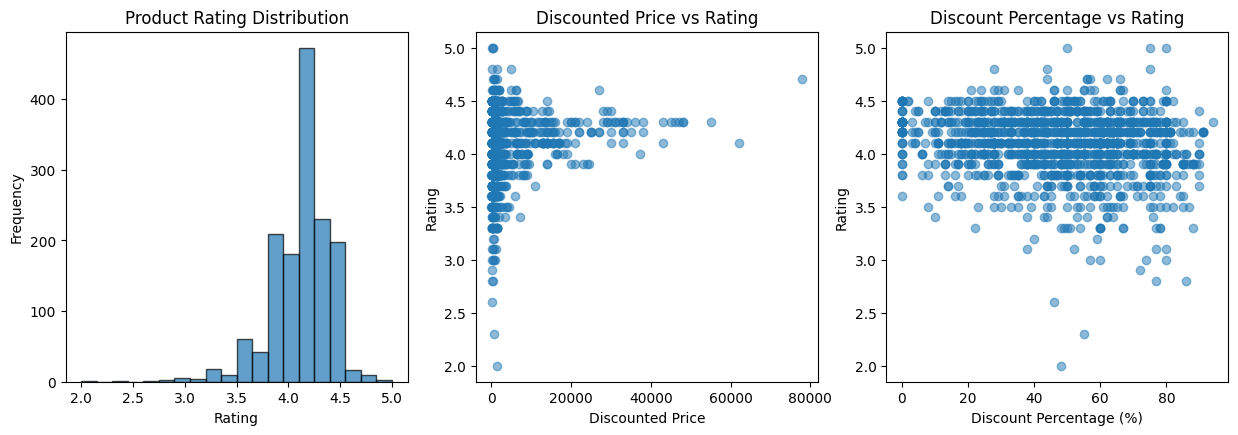

In [12]:
## 4. Exploratory Data Analysis (EDA)

print("\n" + "="*50)
print("4. Exploratory Data Analysis")
print("="*50)

# Create visualizations
plt.figure(figsize=(15, 10))

# 4.1 Target variable distribution
plt.subplot(2, 3, 1)
plt.hist(df['rating'], bins=20, edgecolor='black', alpha=0.7)
plt.title('Product Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# 4.2 Price vs Rating relationship
plt.subplot(2, 3, 2)
plt.scatter(df['discounted_price_clean'], df['rating'], alpha=0.5)
plt.title('Discounted Price vs Rating')
plt.xlabel('Discounted Price')
plt.ylabel('Rating')

# 4.3 Discount vs Rating relationship
plt.subplot(2, 3, 3)
plt.scatter(df['discount_percentage_clean'], df['rating'], alpha=0.5)
plt.title('Discount Percentage vs Rating')
plt.xlabel('Discount Percentage (%)')
plt.ylabel('Rating')

Create multiple visual charts to analyze data:

1.Score distribution histogram: Shows the distribution of the target variable,we can see the rating appeare mostly between 4.0-4.5.

2.Discount Price and Rating Distribution point chart: Analyzing the Relationship between price and rating,we can see that in the area with lower discount prices (close to 0), the rating distribution is relatively wide, with several points ranging from 2.0 to 5.0, indicating that the ratings of goods with low discount prices vary greatly, with both high and low ratings existing.As the discount prices increase, the data points as a whole show a trend: the ratings are relatively concentrated between 3.5 and 4.5, and the number of goods with high discount prices (such as close to 80,000) is relatively small, but the ratings are mostly 4.5 or above. Overall, there is no obvious strong linear correlation, but the approximate distribution characteristics of commodity ratings in different discount price ranges can be observed.

3.Discount percentage and Rating Scatter plot: Analyzing the relationship between discount intensity and rating.we can see that The scattered point distribution is relatively dispersed, indicating that there is no obvious linear correlation between the discount percentage and the score.

These visualizations help understand the relationship between data characteristics and target variables

8. Feature Encoding and Processing

In [16]:
# 5.1 Prepare numerical features
numeric_features = [
    'discounted_price_clean', 'actual_price_clean', 'discount_percentage_clean',
    'rating_count_clean', 'price_ratio', 'absolute_savings',
    'product_name_length', 'about_product_length', 'category_depth'
]

# 5.2 Encode categorical features
le_category = LabelEncoder()
df['main_category_encoded'] = le_category.fit_transform(df['main_category'])

# 5.3 Process text features (product description)
print("Processing product description text features...")
try:
    tfidf = TfidfVectorizer(max_features=100, stop_words='english', lowercase=True)
    text_features = tfidf.fit_transform(df['about_product']).toarray()
    print(f"TF-IDF feature extraction successful, number of features: {text_features.shape[1]}")
except Exception as e:
    print(f"TF-IDF feature extraction failed: {e}")
    print("Using basic text features instead...")
    text_features = np.zeros((len(df), 10))  # Create dummy text features

# Create text feature column names
text_feature_names = [f'tfidf_{i}' for i in range(text_features.shape[1])]

Processing product description text features...
TF-IDF feature extraction successful, number of features: 100


Define the list of numerical features

Encode the category features:

    Use LabelEncoder to convert the main category to a numerical value

Processing text features:

    Vectorize the product description text using TF-IDF
    Extract up to 100 features
    Remove the stop words in English
    Convert to lowercase
    Exception handling: If TF-IDF extraction fails, create virtual features

9. Feature Combination and Inspection

In [17]:
# 5.4 Combine all features
features_numeric = df[numeric_features + ['main_category_encoded']].values
features_combined = np.hstack([features_numeric, text_features])

# Create feature name list
feature_names = numeric_features + ['main_category_encoded'] + text_feature_names

print(f"Final feature count: {features_combined.shape[1]}")
print(f"Sample count: {features_combined.shape[0]}")

# Check for invalid values in features
print(f"Invalid values in feature matrix: {np.isnan(features_combined).sum()}")
print(f"Infinite values in feature matrix: {np.isinf(features_combined).sum()}")

# Replace invalid values
features_combined = np.nan_to_num(features_combined, nan=0.0, posinf=0.0, neginf=0.0)

Final feature count: 110
Sample count: 1464
Invalid values in feature matrix: 0
Infinite values in feature matrix: 0


Combine all features: 

    Merge the numerical features with the encoded category features
    Use np.hstack to stack numerical features and text features horizontally

Create a list of feature names

Check the invalid values (NaN and infinite values) in the feature matrix

Replace invalid values:

    Replace NaN with 0
    Positive infinity is replaced by 0
    Negative infinity is replaced by 0

10. Model Construction and Training

In [19]:
# 6.1 Prepare training data
X = features_combined
y = df['rating'].values

print(f"Final training data shape: X={X.shape}, y={y.shape}")
print(f"Target variable range: {y.min():.2f} - {y.max():.2f}")

# 6.2 Data splitting
# Simplified stratification strategy
try:
    y_binned = pd.cut(y, bins=3, labels=False)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y_binned
    )
except Exception as e:
    print(f"Stratified sampling failed, using random sampling: {e}")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# 6.3 Feature standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Final training data shape: X=(1464, 110), y=(1464,)
Target variable range: 2.00 - 5.00
Training set size: (1171, 110)
Test set size: (293, 110)


Prepare the training data: 

    Set the feature matrix X and the target variable y
    Display the data shape and the range of the target variable

Data splitting：

    Try to use stratified sampling (grouped by score)
    If stratified sampling fails, random sampling shall be used
    80% training set, 20% test set
    Fixed random seeds ensure the reproducibility of the results

Feature standardization：

    Standardize the features using StandardScaler
    Fit and transform the training set
    Only convert the test set (to avoid data leakage)

11. Model Definition and Training

In [20]:
# 6.4 Define 4 main models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# 6.5 Train and evaluate models
results = {}

for name, model in models.items():
    print(f"\nTraining {name} model...")
    
    try:
        # For models requiring standardization, use standardized data
        if name in ['Linear Regression']:
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
        else:
            X_train_model = X_train
            X_test_model = X_test
        
        # Train model
        model.fit(X_train_model, y_train)
        
        # Predict
        y_pred_train = model.predict(X_train_model)
        y_pred_test = model.predict(X_test_model)
        
        # Evaluation metrics
        train_mse = mean_squared_error(y_train, y_pred_train)
        test_mse = mean_squared_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_model, y_train, cv=5, scoring='r2')
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()
        
        results[name] = {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_r2': train_r2,
            'test_r2': test_r2,
            'test_mae': test_mae,
            'cv_mean': cv_mean,
            'cv_std': cv_std,
            'model': model,
            'predictions': y_pred_test
        }
        
        print(f"Training set R²: {train_r2:.4f}")
        print(f"Test set R²: {test_r2:.4f}")
        print(f"Test set MSE: {test_mse:.4f}")
        print(f"Test set MAE: {test_mae:.4f}")
        print(f"Cross-validation R² (mean±std): {cv_mean:.4f} ± {cv_std:.4f}")
        
    except Exception as e:
        print(f"Model {name} training failed: {e}")


Training Linear Regression model...
Training set R²: 0.2717
Test set R²: 0.1252
Test set MSE: 0.0844
Test set MAE: 0.2039
Cross-validation R² (mean±std): 0.0716 ± 0.0668

Training Random Forest model...
Training set R²: 0.8958
Test set R²: 0.2604
Test set MSE: 0.0713
Test set MAE: 0.1775
Cross-validation R² (mean±std): 0.2065 ± 0.0738

Training Gradient Boosting model...
Training set R²: 0.6061
Test set R²: 0.2405
Test set MSE: 0.0733
Test set MAE: 0.1902
Cross-validation R² (mean±std): 0.1191 ± 0.0703

Training XGBoost model...
Training set R²: 0.9780
Test set R²: 0.2337
Test set MSE: 0.0739
Test set MAE: 0.1794
Cross-validation R² (mean±std): 0.0985 ± 0.1001


Define four regression models:

    Linear regression: The most fundamental regression model
    Random Forest: An ensemble model based on decision trees, 100 trees
    Gradient boosting: An integrated model based on gradient boosting, 100 trees
    XGBoost: Efficient gradient boosting implementation, 100 trees

Train and evaluate each model:
    Choose whether to use standardized data based on the model type

    Train the model and make predictions
    
    Calculate multiple evaluation indicators:

        Mean square Error (MSE) : Training set and test set
        Determination coefficient (R²) : Training set and test set
        Mean Absolute Error (MAE) : Test set

    Perform 5-fold cross-validation and calculate the average R² and standard deviation

    Store all the results and model objects

    Exception handling: Capture and display the error of training failure

12. Model Performance comparison


Model performance ranking (by Test R²):
            Model  Train R²  Test R²  Test MSE  Test MAE  CV Mean R²  CV Std R²
    Random Forest  0.895837 0.260429  0.071345  0.177526    0.206508   0.073766
Gradient Boosting  0.606092 0.240540  0.073264  0.190215    0.119089   0.070290
          XGBoost  0.977999 0.233673  0.073926  0.179369    0.098494   0.100063
Linear Regression  0.271718 0.125209  0.084389  0.203895    0.071620   0.066784


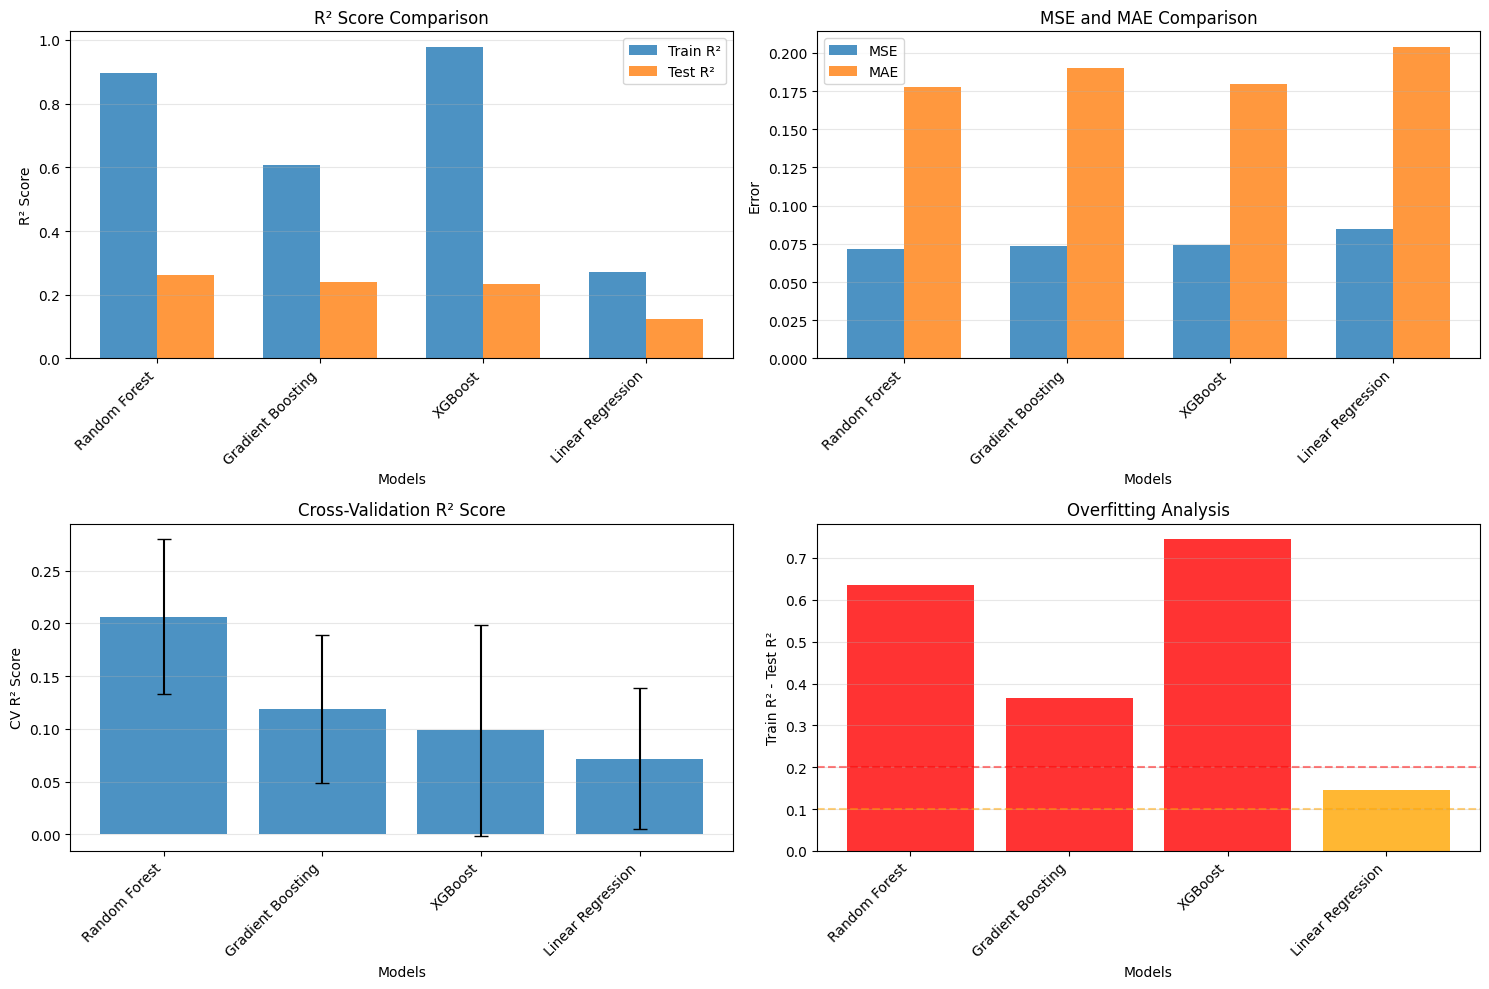

In [24]:
# Create performance comparison DataFrame
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Test R²': [results[m]['test_r2'] for m in results.keys()],
    'Test MSE': [results[m]['test_mse'] for m in results.keys()],
    'Test MAE': [results[m]['test_mae'] for m in results.keys()],
    'CV Mean R²': [results[m]['cv_mean'] for m in results.keys()],
    'CV Std R²': [results[m]['cv_std'] for m in results.keys()]
})

# Sort by Test R²
performance_df = performance_df.sort_values('Test R²', ascending=False)
print("\nModel performance ranking (by Test R²):")
print(performance_df.to_string(index=False))

# Create performance comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 7.1 R² comparison
ax = axes[0, 0]
x = np.arange(len(performance_df))
width = 0.35
ax.bar(x - width/2, performance_df['Train R²'], width, label='Train R²', alpha=0.8)
ax.bar(x + width/2, performance_df['Test R²'], width, label='Test R²', alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('R² Score')
ax.set_title('R² Score Comparison')
ax.set_xticks(x)
ax.set_xticklabels(performance_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 7.2 MSE and MAE comparison
ax = axes[0, 1]
x = np.arange(len(performance_df))
ax.bar(x - width/2, performance_df['Test MSE'], width, label='MSE', alpha=0.8)
ax.bar(x + width/2, performance_df['Test MAE'], width, label='MAE', alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('Error')
ax.set_title('MSE and MAE Comparison')
ax.set_xticks(x)
ax.set_xticklabels(performance_df['Model'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

# 7.3 Cross-validation scores
ax = axes[1, 0]
ax.bar(x, performance_df['CV Mean R²'], yerr=performance_df['CV Std R²'], capsize=5, alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('CV R² Score')
ax.set_title('Cross-Validation R² Score')
ax.set_xticks(x)
ax.set_xticklabels(performance_df['Model'], rotation=45, ha='right')
ax.grid(axis='y', alpha=0.3)

# 7.4 Overfitting analysis
ax = axes[1, 1]
overfitting = performance_df['Train R²'] - performance_df['Test R²']
colors = ['green' if x < 0.1 else 'orange' if x < 0.2 else 'red' for x in overfitting]
ax.bar(x, overfitting, color=colors, alpha=0.8)
ax.set_xlabel('Models')
ax.set_ylabel('Train R² - Test R²')
ax.set_title('Overfitting Analysis')
ax.set_xticks(x)
ax.set_xticklabels(performance_df['Model'], rotation=45, ha='right')
ax.axhline(y=0.1, color='orange', linestyle='--', alpha=0.5)
ax.axhline(y=0.2, color='red', linestyle='--', alpha=0.5)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{output_dir}/model_performance_comparison.png', bbox_inches='tight')
plt.show()

Create a performance comparison data frame:

    Summarize the performance indicators of all models
    Including the training set R², the test set R², the test set MSE, the test set MAE, the mean and standard deviation of cross-validation R²

Arrange the models in descending order of the test set R²

Display the model performance ranking table

Create performance comparison visualization:

    Set the subgraph layout of 2x2
    
    The first subgraph: R² comparison bar chart

        Compare the training set and test set R² of each model
        Display the model name, legend and grid lines
Continue to create performance comparison visualizations:

    The second subgraph: A bar chart comparing MSE and MAE

        Compare the test sets MSE and MAE of each model

    The third subgraph: Cross-validation R² bar chart

        Display the cross-validation R² mean of each model
        Use the error line to display the standard deviation

    The fourth subgraph: Bar chart of overfitting analysis
    
        Calculate the difference between the training set R² and the test set R²
        Use different colors (green, orange, red) according to the size of the difference.
        Adding reference lines of 0.1 and 0.2 indicates the degree of overfitting

13. Optimal Model Analysis

Best model: Random Forest
Test set R²: 0.2604
Test set MAE: 0.1775


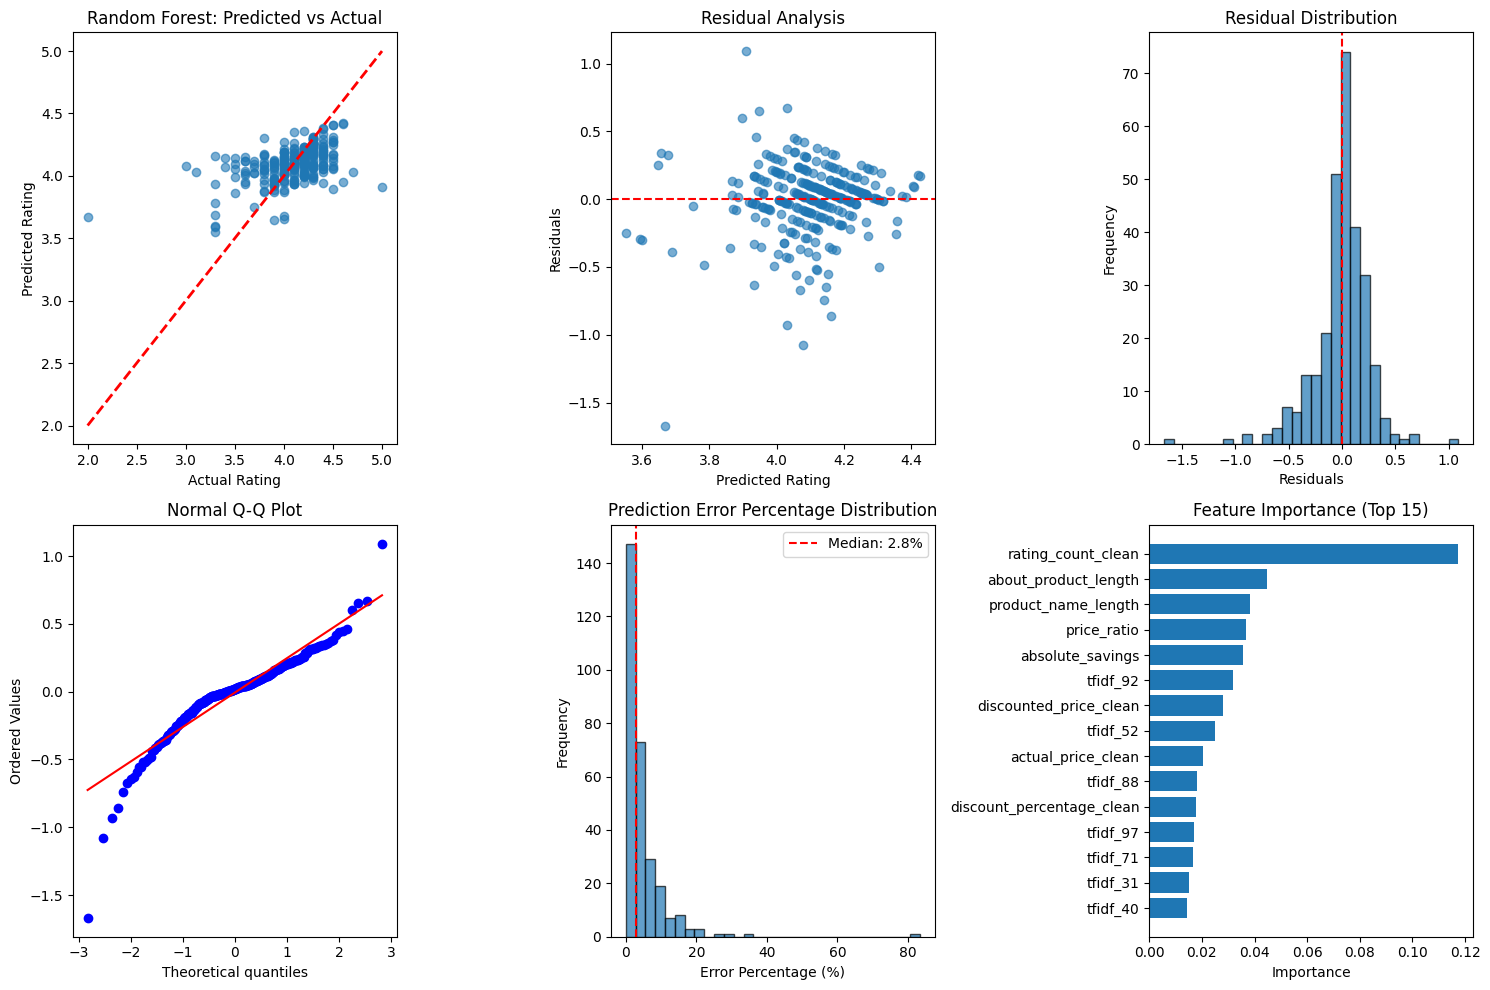

In [29]:
# Select best model
best_model_name = performance_df.iloc[0]['Model']
best_model = results[best_model_name]['model']
y_pred_best = results[best_model_name]['predictions']

print(f"Best model: {best_model_name}")
print(f"Test set R²: {performance_df.iloc[0]['Test R²']:.4f}")
print(f"Test set MAE: {performance_df.iloc[0]['Test MAE']:.4f}")

# Create detailed analysis graphs for best model
plt.figure(figsize=(15, 10))

# 8.1 Predicted vs Actual values
plt.subplot(2, 3, 1)
plt.scatter(y_test, y_pred_best, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.title(f'{best_model_name}: Predicted vs Actual')

# 8.2 Residual analysis
plt.subplot(2, 3, 2)
residuals = y_test - y_pred_best
plt.scatter(y_pred_best, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Rating')
plt.ylabel('Residuals')
plt.title('Residual Analysis')

# 8.3 Residual distribution
plt.subplot(2, 3, 3)
plt.hist(residuals, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.axvline(x=0, color='r', linestyle='--')

# 8.4 QQ Plot
plt.subplot(2, 3, 4)
from scipy import stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot')

# 8.5 Prediction error percentage analysis
plt.subplot(2, 3, 5)
error_percentages = np.abs(residuals) / y_test * 100
plt.hist(error_percentages, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Error Percentage (%)')
plt.ylabel('Frequency')
plt.title('Prediction Error Percentage Distribution')
plt.axvline(x=np.median(error_percentages), color='r', linestyle='--', label=f'Median: {np.median(error_percentages):.1f}%')
plt.legend()

# 8.6 Feature importance (if model supports it)
plt.subplot(2, 3, 6)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    top_indices = np.argsort(feature_importance)[-15:]
    top_features = [feature_names[i] for i in top_indices]
    top_importance = feature_importance[top_indices]
    
    plt.barh(range(len(top_features)), top_importance)
    plt.yticks(range(len(top_features)), top_features)
    plt.xlabel('Importance')
    plt.title('Feature Importance (Top 15)')
else:
    plt.text(0.5, 0.5, 'Feature importance not available\nfor this model type', 
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Feature Importance')

plt.tight_layout()
plt.savefig(f'{output_dir}/best_model_analysis.png', bbox_inches='tight')
plt.show()

Select the model with the best performance (sorted by the test set R²)

Display the name of the best model and the key performance indicators

Detailed analysis chart for creating the best model:

    The first subgraph: Scatter plot of predicted values and actual values
    
        Add the ideal prediction line (y=x) as a reference

    The second subgraph: Residual analysis scatter plot

        Calculate the residual (actual value - predicted value)
        Add the neutral line as a reference
        The pattern used for checking the prediction error

    The third subgraph: Histogram of residual distribution

        Show the distribution of the prediction error
        Add the neutral line as a reference

    The fourth subgraph: Normal Q-Q graph

        Test whether the residuals follow a normal distribution
        If the point is on a straight line, it indicates that the residuals are close to a normal distribution

    The fifth subgraph: Percentage analysis of prediction error

        Calculate the percentage of relative error
        Draw the histogram of the percentage error distribution
        Mark the percentage of median error

The sixth subgraph: Feature Importance (if supported by the model)

        Extract and display the top 15 most important features
        If the model does not support feature importance (such as linear regression), prompt information will be displayed

14.Model optimization

In [30]:
## 9. Model Optimization (for the best model)

print("\n" + "="*50)
print("9. Model Optimization")
print("="*50)

# If the best model is a tree model, perform hyperparameter optimization
if best_model_name in ['Random Forest', 'Gradient Boosting', 'XGBoost']:
    print(f"\nOptimizing hyperparameters for {best_model_name}...")
    
    # Define parameter grid
    if best_model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    elif best_model_name == 'Gradient Boosting':
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5]
        }
    else:  # XGBoost
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1, 0.15],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3]
        }
    
    # Grid search
    grid_search = GridSearchCV(
        type(best_model)(),
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation R²: {grid_search.best_score_:.4f}")
    
    # Use best parameters to retrain
    optimized_model = grid_search.best_estimator_
    y_pred_optimized = optimized_model.predict(X_test)
    
    optimized_r2 = r2_score(y_test, y_pred_optimized)
    optimized_mae = mean_absolute_error(y_test, y_pred_optimized)
    
    print(f"\nOptimized performance:")
    print(f"Test set R²: {optimized_r2:.4f} (original: {performance_df.iloc[0]['Test R²']:.4f})")
    print(f"Test set MAE: {optimized_mae:.4f} (original: {performance_df.iloc[0]['Test MAE']:.4f})")
    
    # Update best model
    if optimized_r2 > performance_df.iloc[0]['Test R²']:
        best_model = optimized_model
        y_pred_best = y_pred_optimized
        print("\nOptimized model performance better, updated best model")


9. Model Optimization

Optimizing hyperparameters for Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best cross-validation R²: 0.2209

Optimized performance:
Test set R²: 0.2496 (original: 0.2604)
Test set MAE: 0.1796 (original: 0.1775)


Perform hyperparameter optimization on the best model (applicable only to tree models) :

    Determine whether the best model is a tree model (random forest, gradient boosting or XGBoost)
    Define different parameter grids according to the model type:

        Random Forest: Adjust the number of trees, maximum depth, split, and leaf node parameters
        Gradient boosting: Adjust the number of trees, learning rate, maximum depth and split parameters
        XGBoost: Adjust the number of trees, learning rate, maximum depth and minimum sub-weight
Use grid search and 5-fold cross-validation to find the best parameter combination

Retrain the model using the best parameters

Evaluate the performance of the optimized model and compare it with the original model

15.Model prediction comparison


10. All models prediction results comparison


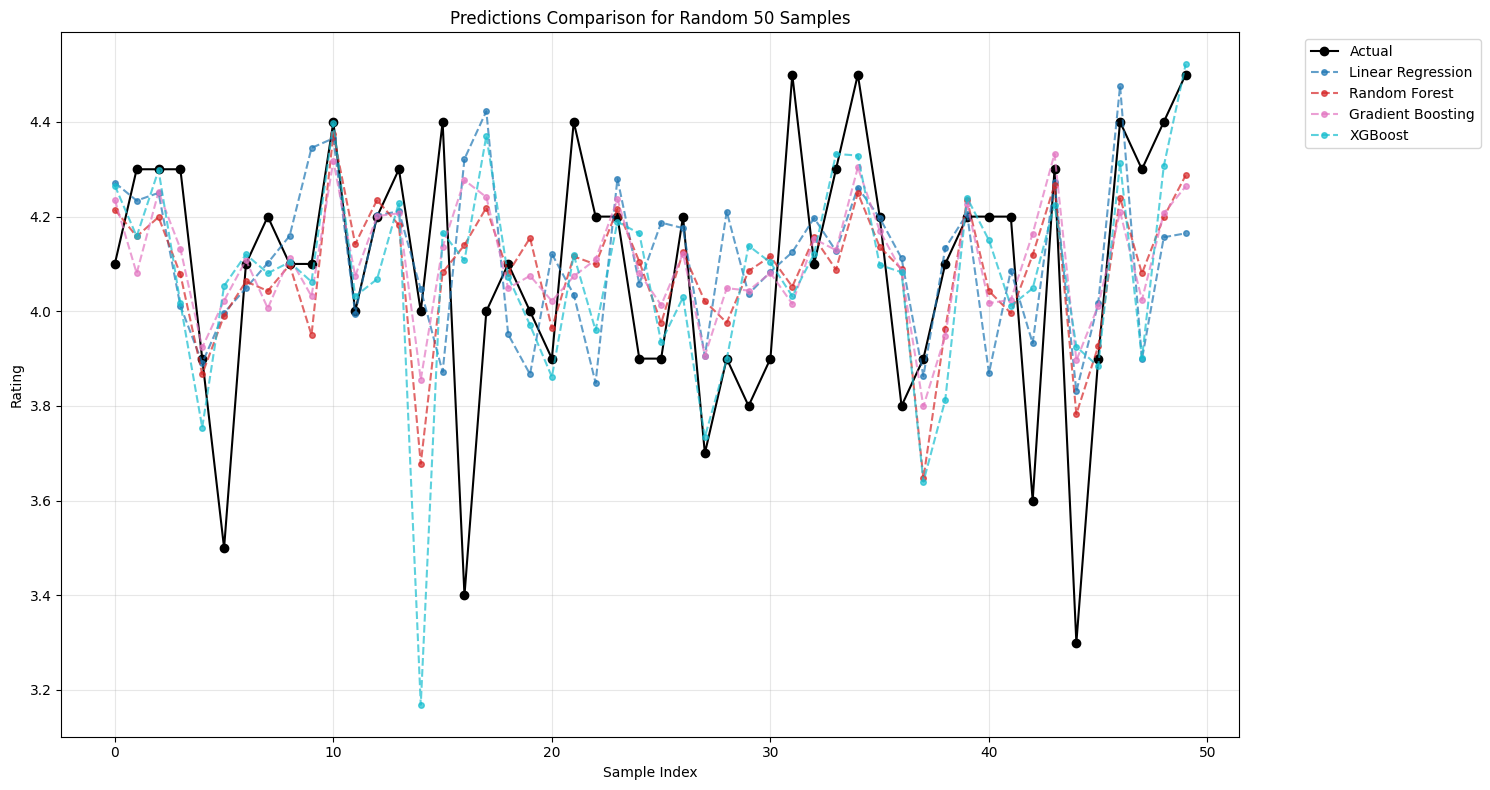

In [31]:
## 10. All models prediction results comparison

print("\n" + "="*50)
print("10. All models prediction results comparison")
print("="*50)

# Create prediction comparison chart
n_samples_to_show = 50
indices = np.random.choice(len(y_test), n_samples_to_show, replace=False)

plt.figure(figsize=(15, 8))

# Prepare data
predictions_data = {'Actual': y_test[indices]}
for model_name in results.keys():
    predictions_data[model_name] = results[model_name]['predictions'][indices]

# Create DataFrame
predictions_df = pd.DataFrame(predictions_data)

# Plot predictions for first 50 samples
plt.plot(range(n_samples_to_show), predictions_df['Actual'], 'ko-', label='Actual', markersize=6)

colors = plt.cm.tab10(np.linspace(0, 1, len(results)))
for i, model_name in enumerate(results.keys()):
    plt.plot(range(n_samples_to_show), predictions_df[model_name], 'o--', 
             color=colors[i], label=model_name, alpha=0.7, markersize=4)

plt.xlabel('Sample Index')
plt.ylabel('Rating')
plt.title('Predictions Comparison for Random 50 Samples')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{output_dir}/predictions_comparison.png', bbox_inches='tight')
plt.show()

Create a comparison chart of all the model prediction results:

    Fifty test samples were randomly selected
    Create a data frame containing the actual values and all the predicted values of the model
    Draw the actual rating value (black solid line)
    Draw the predicted values (dotted lines) of each model using different colors.

This visualization visually presents the differences and accuracies of predictions made by different models

16.Analysis of prediction accuracy


11. Prediction accuracy analysis


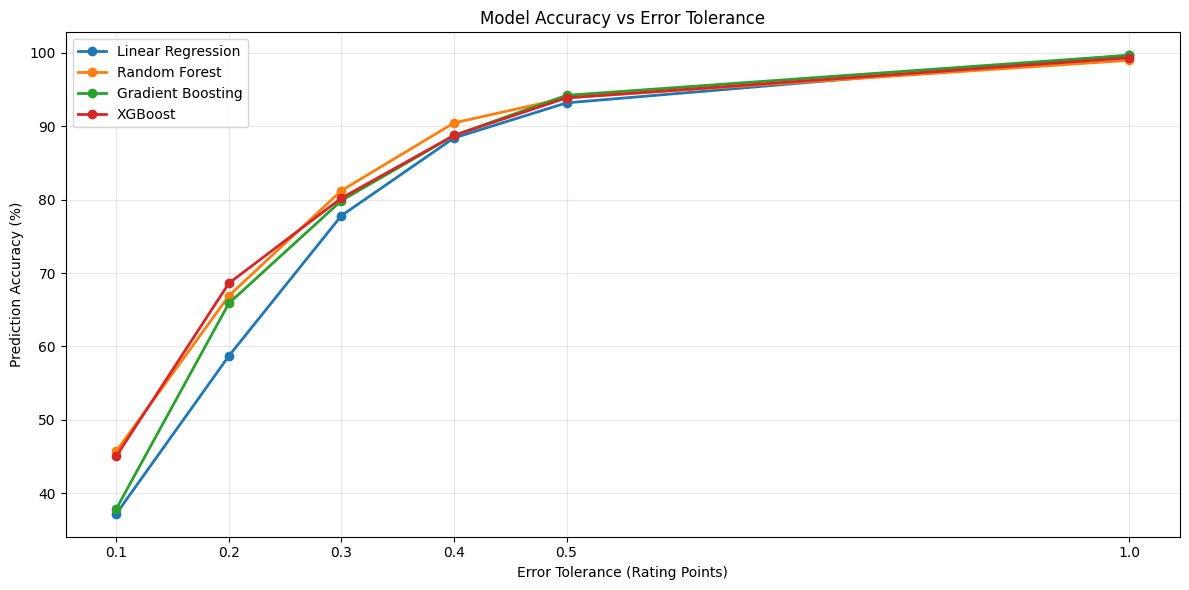


Model accuracy (% in different error tolerance ranges):
      Linear Regression  Random Forest  Gradient Boosting  XGBoost
±0.1               37.2           45.7               37.9     45.1
±0.2               58.7           66.9               65.9     68.6
±0.3               77.8           81.2               79.9     80.2
±0.4               88.4           90.4               88.7     88.7
±0.5               93.2           93.9               94.2     93.9
±1.0               99.7           99.0               99.7     99.3


In [32]:
## 11. Prediction accuracy analysis

print("\n" + "="*50)
print("11. Prediction accuracy analysis")
print("="*50)

# Calculate accuracy for different error tolerance ranges
tolerance_levels = [0.1, 0.2, 0.3, 0.4, 0.5, 1.0]
accuracy_results = {}

for model_name in results.keys():
    y_pred = results[model_name]['predictions']
    residuals = np.abs(y_test - y_pred)
    
    accuracies = []
    for tol in tolerance_levels:
        accuracy = np.mean(residuals <= tol) * 100
        accuracies.append(accuracy)
    
    accuracy_results[model_name] = accuracies

# Create accuracy comparison chart
plt.figure(figsize=(12, 6))

for model_name, accuracies in accuracy_results.items():
    plt.plot(tolerance_levels, accuracies, marker='o', label=model_name, linewidth=2)

plt.xlabel('Error Tolerance (Rating Points)')
plt.ylabel('Prediction Accuracy (%)')
plt.title('Model Accuracy vs Error Tolerance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(tolerance_levels)
plt.tight_layout()
plt.savefig(f'{output_dir}/accuracy_vs_tolerance.png', bbox_inches='tight')
plt.show()

# Print accuracy table
accuracy_df = pd.DataFrame(accuracy_results, index=[f'±{tol}' for tol in tolerance_levels])
print("\nModel accuracy (% in different error tolerance ranges):")
print(accuracy_df.round(1))
accuracy_df.to_csv(f'{output_dir}/accuracy_analysis.csv')

Analyze the prediction accuracy under different error tolerance ranges:

    Define multiple error tolerance levels (from 0.1 to 1.0)

    Calculate the accuracy rate of each model under different tolerance levels

        Accuracy rate = the percentage of samples whose error is less than or equal to the tolerance value
        
Create an accuracy comparison chart:

    The horizontal axis represents the error tolerance value
    The vertical axis represents the percentage of prediction accuracy
    Draw a line for each model
    Create and display the accuracy table

Save the accuracy analysis results as a CSV file

17.Model saving

In [33]:
## 12. Model saving

print("\n" + "="*50)
print("12. Model saving")
print("="*50)

try:
    # Save all models
    for model_name, model_info in results.items():
        model_filename = f"{output_dir}/{model_name.replace(' ', '_').lower()}_model.pkl"
        joblib.dump(model_info['model'], model_filename)
        print(f"{model_name} model saved: {model_filename}")
    
    # Save best model and related components
    joblib.dump(best_model, f'{output_dir}/best_model.pkl')
    joblib.dump(scaler, f'{output_dir}/scaler.pkl')
    joblib.dump(tfidf, f'{output_dir}/tfidf.pkl')
    joblib.dump(le_category, f'{output_dir}/label_encoder.pkl')
    
    # Save model information
    model_info = {
        'best_model_name': best_model_name,
        'feature_names': feature_names,
        'performance_metrics': performance_df.to_dict()
    }
    joblib.dump(model_info, f'{output_dir}/model_info.pkl')
    
    print(f"\nBest model ({best_model_name}) and related components saved")
    
except Exception as e:
    print(f"Model saving failed: {e}")


12. Model saving
Linear Regression model saved: model_results/linear_regression_model.pkl
Random Forest model saved: model_results/random_forest_model.pkl
Gradient Boosting model saved: model_results/gradient_boosting_model.pkl
XGBoost model saved: model_results/xgboost_model.pkl

Best model (Random Forest) and related components saved


Save all the trained models and related components: 

    Save each model to a separate file

        File name format: The model name should be in lowercase with underscores replacing Spaces

Save the best model and its related components:

    Best model
    Feature standardizer
    TF-IDF vectorizer
    Category label encoder

Save model information:

    Best Model name
    List of feature names
    Performance index
    
Exception handling: Capture and display the error of failed save

18.Generate the final report

In [34]:
## 13. Generate final report

print("\n" + "="*50)
print("13. Final report")
print("="*50)

# Create comprehensive report
report_content = f"""
# Amazon Product Rating Prediction Model Report

## 1. Data Overview
- Total sample count: {len(df)}
- Feature count: {X.shape[1]}
- Rating range: {y.min():.2f} - {y.max():.2f}
- Average rating: {y.mean():.2f} ± {y.std():.2f}

## 2. Model Performance Comparison
{performance_df.to_string()}

## 3. Best Model
- Model type: {best_model_name}
- Test set R²: {performance_df.iloc[0]['Test R²']:.4f}
- Test set MAE: {performance_df.iloc[0]['Test MAE']:.4f}
- Test set MSE: {performance_df.iloc[0]['Test MSE']:.4f}

## 4. Accuracy Analysis
Prediction accuracy within ±0.5 rating points:
{accuracy_df.loc['±0.5'].to_string()}

## 5. Business Insight
1. Most important features include rating count, price-related features, and product description
2. Suggest merchants focus on product description quality and reasonable pricing
3. Encourage more user ratings to improve product credibility

## 6. Model Application Suggestions
- {best_model_name} model performs best on this dataset
- Model can be used to predict potential ratings for new products
- Suggest regularly updating the model to maintain prediction accuracy
"""

# Save report
with open(f'{output_dir}/model_report.txt', 'w', encoding='utf-8') as f:
    f.write(report_content)

print(report_content)

print("\n" + "="*60)
print("Project completed! All results saved to 'model_results' directory")
print("="*60)


13. Final report

# Amazon Product Rating Prediction Model Report

## 1. Data Overview
- Total sample count: 1464
- Feature count: 110
- Rating range: 2.00 - 5.00
- Average rating: 4.10 ± 0.29

## 2. Model Performance Comparison
               Model  Train R²   Test R²  Test MSE  Test MAE  CV Mean R²  CV Std R²
1      Random Forest  0.895837  0.260429  0.071345  0.177526    0.206508   0.073766
2  Gradient Boosting  0.606092  0.240540  0.073264  0.190215    0.119089   0.070290
3            XGBoost  0.977999  0.233673  0.073926  0.179369    0.098494   0.100063
0  Linear Regression  0.271718  0.125209  0.084389  0.203895    0.071620   0.066784

## 3. Best Model
- Model type: Random Forest
- Test set R²: 0.2604
- Test set MAE: 0.1775
- Test set MSE: 0.0713

## 4. Accuracy Analysis
Prediction accuracy within ±0.5 rating points:
Linear Regression    93.174061
Random Forest        93.856655
Gradient Boosting    94.197952
XGBoost              93.856655

## 5. Business Insight
1. Most importan